In [1]:
import torch
import torch.nn as nn
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import scipy.io as sio
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

from torch.utils.data import DataLoader
from utils.datasets import video_loader

# DPCN + Shrinkage
$$E_1(x_t,y_t,C,A) = \|y_t -Cx_t\|_2^2 + \lambda \|x_t-Ax_{t-1}\| + \| \gamma x_t\|_1$$
$$E_2(u_t,x_t,B) = \| \gamma x_t\|_1+\beta \| u_t\|_1$$ 
$$\gamma=\gamma_0\left[\frac{1+\exp(-Bu)}{2}\right]$$

In [2]:
#method = 'FISTA'

def plot_result(method, dataset):

    U = np.load(os.path.join("runs", method, dataset, "U.npy"))
    X = np.load(os.path.join("runs", method, dataset, "X.npy"))
    recon = np.load(os.path.join("runs", method, dataset, "recon.npy"))
    print("state dim:", X.shape)
    print("cause dim:", U.shape)
    print("recon dim:", recon.shape)

    U_1 = np.mean(np.abs(U), axis=1, keepdims=True)

    new_U = np.zeros((U_1.shape[-1], U_1.shape[0]*U_1.shape[1]*U_1.shape[2]))
    new_X = np.zeros((X.shape[-1], X.shape[0]*X.shape[1]*X.shape[2]))
    for i in range(U_1.shape[-1]):
        sample = U_1[:,:,:,:,i].squeeze()
        new_U[i] = sample.flatten()
        new_X[i] = X[:,:,:,:,i].flatten()

    #scaler = StandardScaler()
    #new_U = scaler.fit_transform(new_U)
    #print(new_U[0].max(), np.abs(new_U[0]).min())
    #print(new_U.shape)

    #print(new_U[0])

    # print(new_X[0].max(), np.abs(new_X[0]).min())
    # plt.imshow(new_X[2].reshape(30,40))
    # plt.show()
    # print(new_X[0])

    pca = PCA(n_components=3)
    U_PCA = pca.fit_transform(new_U)
    # print(U_PCA.shape)
    # plt.scatter(U_PCA[:, 0], U_PCA[:, 1])

    fig = plt.figure(figsize=(15, 15))

    gs = fig.add_gridspec(3,3)
    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, 0], projection='3d')
    ax3 = fig.add_subplot(gs[1, 1])
    ax4 = fig.add_subplot(gs[1, 2])
    ax5 = fig.add_subplot(gs[2, 0])
    ax6 = fig.add_subplot(gs[2, 1])
    ax7 = fig.add_subplot(gs[2, 2])

    ax1.imshow(new_U.T)
    ax1.set_title(f'cause value ({method})')
    ax1.set_xlabel('t')
    ax1.set_ylabel('cause dim')
    
    if dataset == 'geometric':
        indx = [0,]
        for idx in indx:
            ax2.scatter(U_PCA[idx:100+idx, 0], U_PCA[idx:100+idx, 1], U_PCA[idx:100+idx, 2], c='g', marker='o', label='◆')
            ax2.scatter(U_PCA[100+idx:200+idx, 0], U_PCA[100+idx:200+idx, 1], U_PCA[100+idx:200+idx, 2], c='y', marker='o', label='▲')
            ax2.scatter(U_PCA[200+idx:300+idx, 0], U_PCA[200+idx:300+idx, 1], U_PCA[200+idx:300+idx, 2], c='b', marker='o', label='■')
    else:
        indx = [0,]
        for idx in indx:
            ax2.scatter(U_PCA[idx:100+idx, 0], U_PCA[idx:100+idx, 1], U_PCA[idx:100+idx, 2], c='g', marker='o', label='0')
            ax2.scatter(U_PCA[100+idx:200+idx, 0], U_PCA[100+idx:200+idx, 1], U_PCA[100+idx:200+idx, 2], c='y', marker='o', label='1')
            ax2.scatter(U_PCA[200+idx:300+idx, 0], U_PCA[200+idx:300+idx, 1], U_PCA[200+idx:300+idx, 2], c='b', marker='o', label='2')
            ax2.scatter(U_PCA[300+idx:400+idx, 0], U_PCA[300+idx:400+idx, 1], U_PCA[300+idx:400+idx, 2], c='k', marker='o', label='3')
            ax2.scatter(U_PCA[400+idx:500+idx, 0], U_PCA[400+idx:500+idx, 1], U_PCA[400+idx:500+idx, 2], c='r', marker='o', label='4')
    ax2.set_title('clustering result for one video')
    ax2.legend()
    _ = ax3.hist(new_X.flatten(), bins=200)
    ax3.set_title(f'state value histogram ({np.sum(new_X==0)/new_X.size * 100:.2f}%)')
    ax3.set_xlabel('state value')
    ax3.set_ylabel('count')
    _ = ax4.hist(U.flatten(), bins=200)
    ax4.set_title(f'cause value histogram ({np.sum(U==0)/U.size * 100:.2f}%)')
    ax4.set_xlabel('cause value')
    ax4.set_ylabel('count')

    if dataset == 'geometric':
        name1, name2, name3 = 'diamond', 'triangle', 'square'
        idx1, idx2, idx3 = 0, 100, 200
    elif dataset == 'mario':
        name1, name2, name3 = 'goomba', 'koopa', 'mario'
        idx1, idx2, idx3 = 100, 200, 310
    # normalize recon
    recon = (recon - recon.min()) / (recon.max() - recon.min())
    ax5.imshow(recon[:,:,:,idx1].transpose(1,2,0).squeeze(), cmap='gray')
    ax5.axis('off')
    ax5.set_title(name1)
    ax6.imshow(recon[:,:,:,idx2].transpose(1,2,0).squeeze(), cmap='gray')
    ax6.axis('off')
    ax6.set_title(name2)
    ax7.imshow(recon[:,:,:,idx3].transpose(1,2,0).squeeze(), cmap='gray')
    ax7.axis('off')
    ax7.set_title(name3)
    

    plt.show()

state dim: (1, 4, 300, 1, 300)
cause dim: (1, 1, 40, 1, 300)
recon dim: (1, 32, 32, 300)


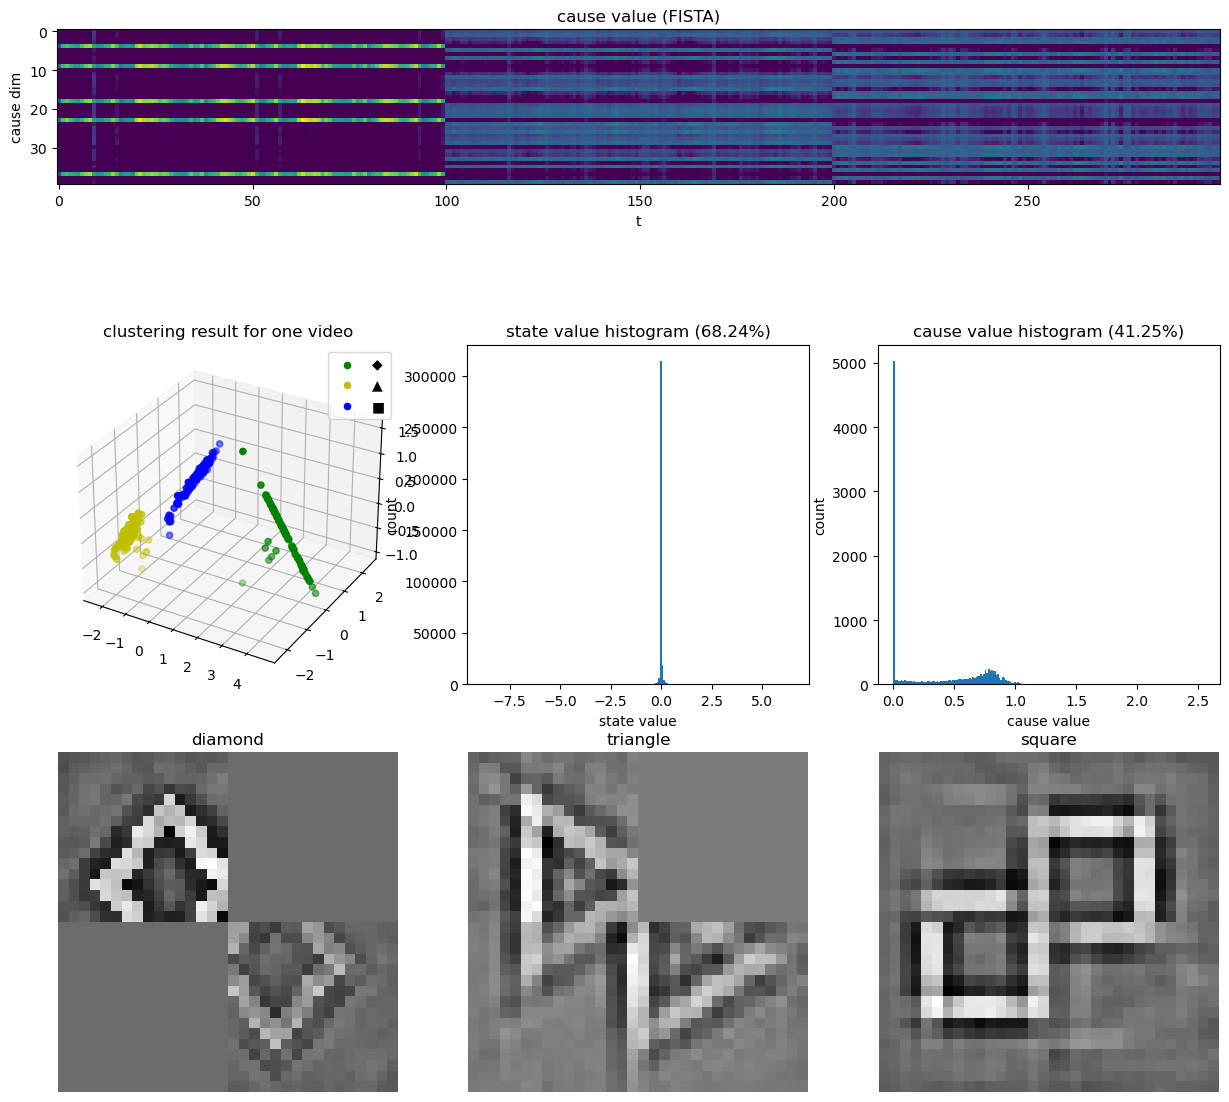

In [82]:
plot_result('FISTA', 'geometric')

state dim: (3, 4, 300, 1, 500)
cause dim: (3, 1, 40, 1, 500)
recon dim: (3, 32, 32, 500)


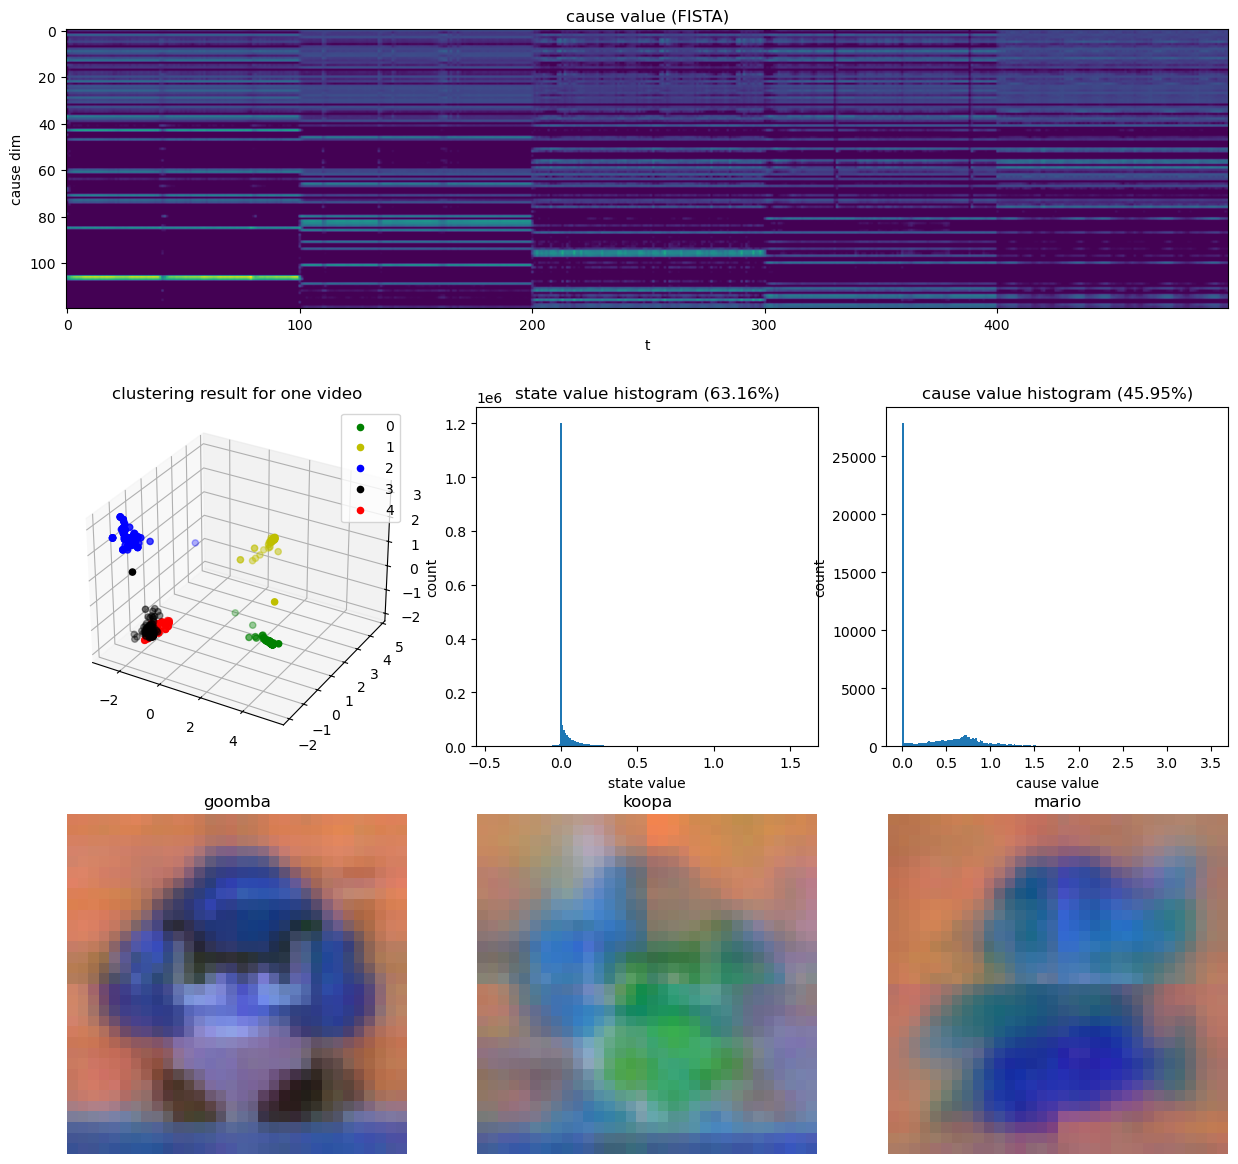

In [81]:
plot_result('FISTA', 'mario')

state dim: (1, 4, 300, 1, 300)
cause dim: (1, 1, 40, 1, 300)
recon dim: (1, 32, 32, 300)


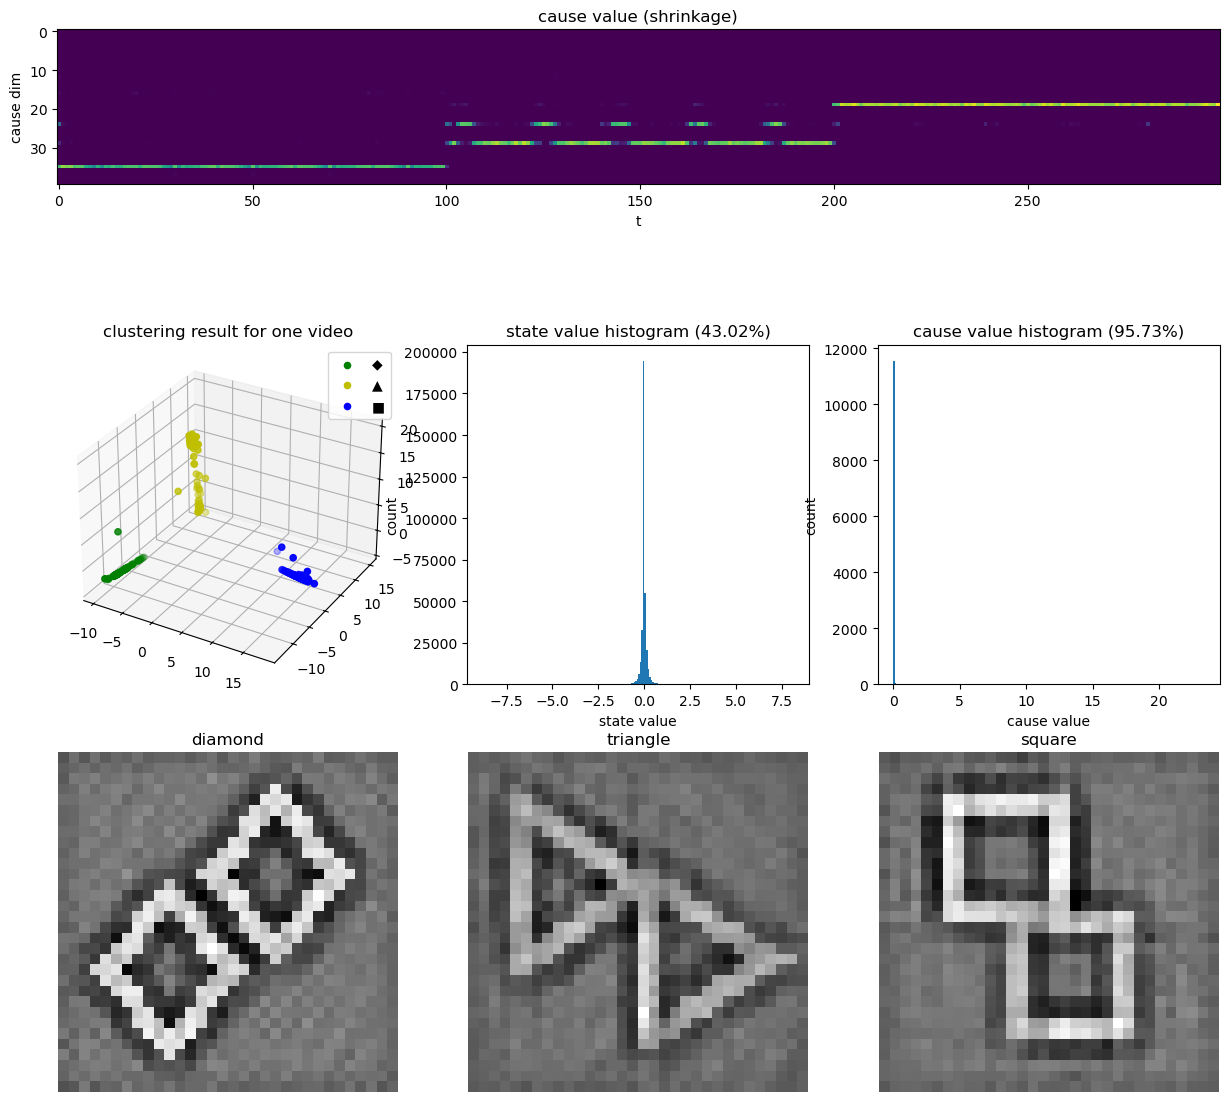

In [4]:
plot_result('shrinkage', 'geometric')

odict_keys(['A', 'B', 'C', 'I_x', 'I_u', 'lam', 'gamma0', 'mu', 'beta'])
torch.Size([1, 1, 256, 300])
torch.Size([1, 1, 256, 50])


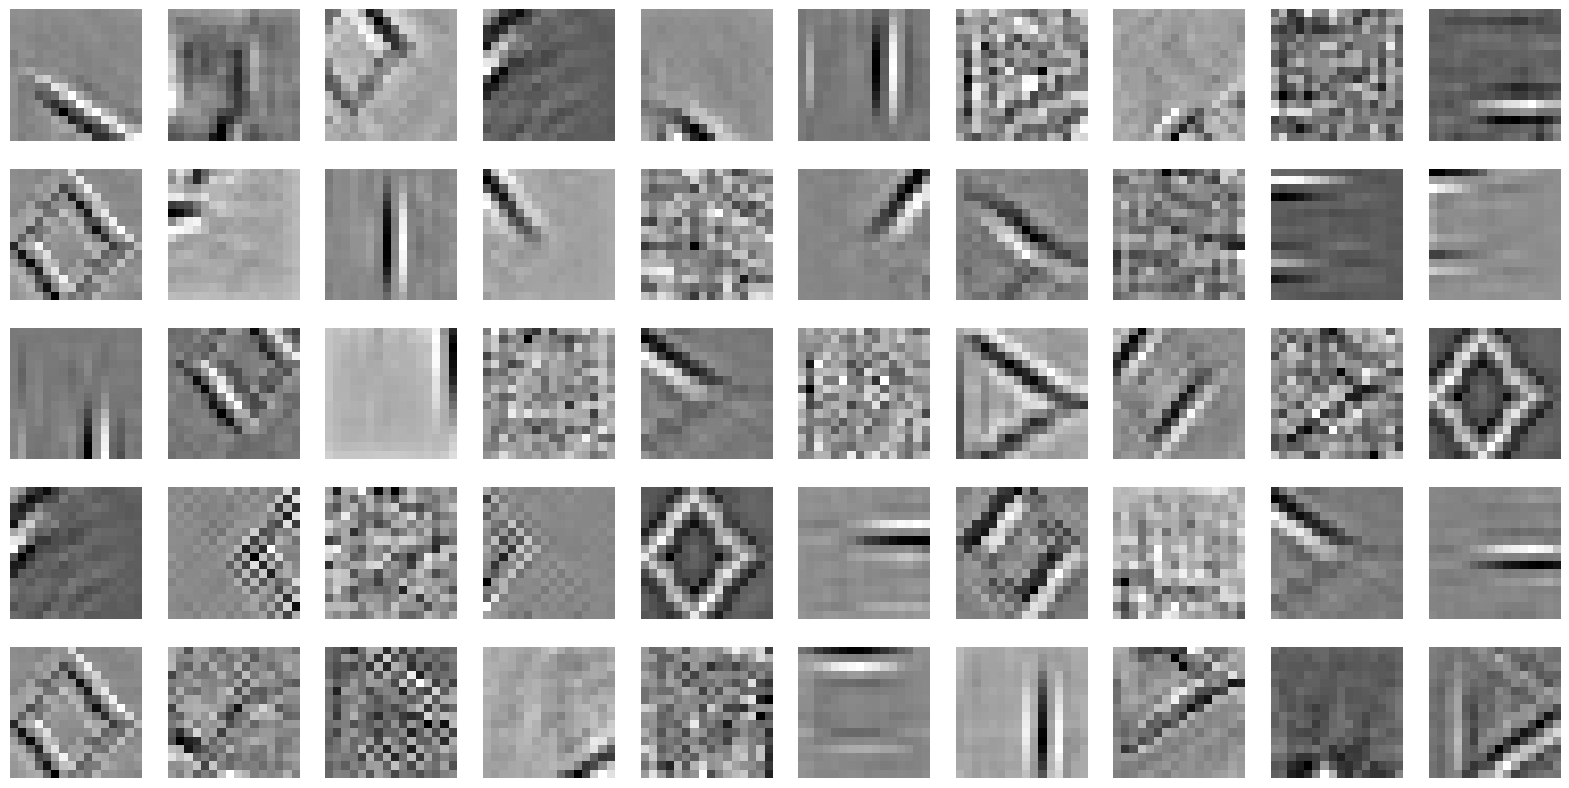

In [5]:
from torchvision.utils import make_grid
import torchvision
param = torch.load('runs/shrinkage/geometric/layer1.pth.tar')
print(param.keys())
print(param['C'].shape)
index = torch.randint(0, 300, (50,))
if len(param['C'].shape) == 4:
    test = param['C'][:,:,:,index]
    n_c = 1
else:
    test = param['C'][:,:,:,:,index]
    n_c = 3
print(test.shape)

test = test.view(1,n_c,16,16,-1).cpu().numpy()
#plt.imshow(test[0,:,:,:,0].transpose(1,2,0).squeeze(), cmap='gray')
#Grid = make_grid(test, nrow=2)
#img = torchvision.transforms.ToPILImage()(Grid) 
#img.show() 

fig, ax = plt.subplots(5,10, figsize=(20,10))

for i in range(50):
    filter = test[0,:,:,:,i].transpose(1,2,0).squeeze()
    # normalize filter 
    filter = (filter - filter.min()) / (filter.max() - filter.min())
    ax[i//10, i%10].imshow(filter, cmap='gray')
    ax[i//10, i%10].axis('off')

In [38]:
len(param['C'].shape)

4

state dim: (3, 4, 300, 1, 500)
cause dim: (3, 1, 40, 1, 500)
recon dim: (3, 32, 32, 500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


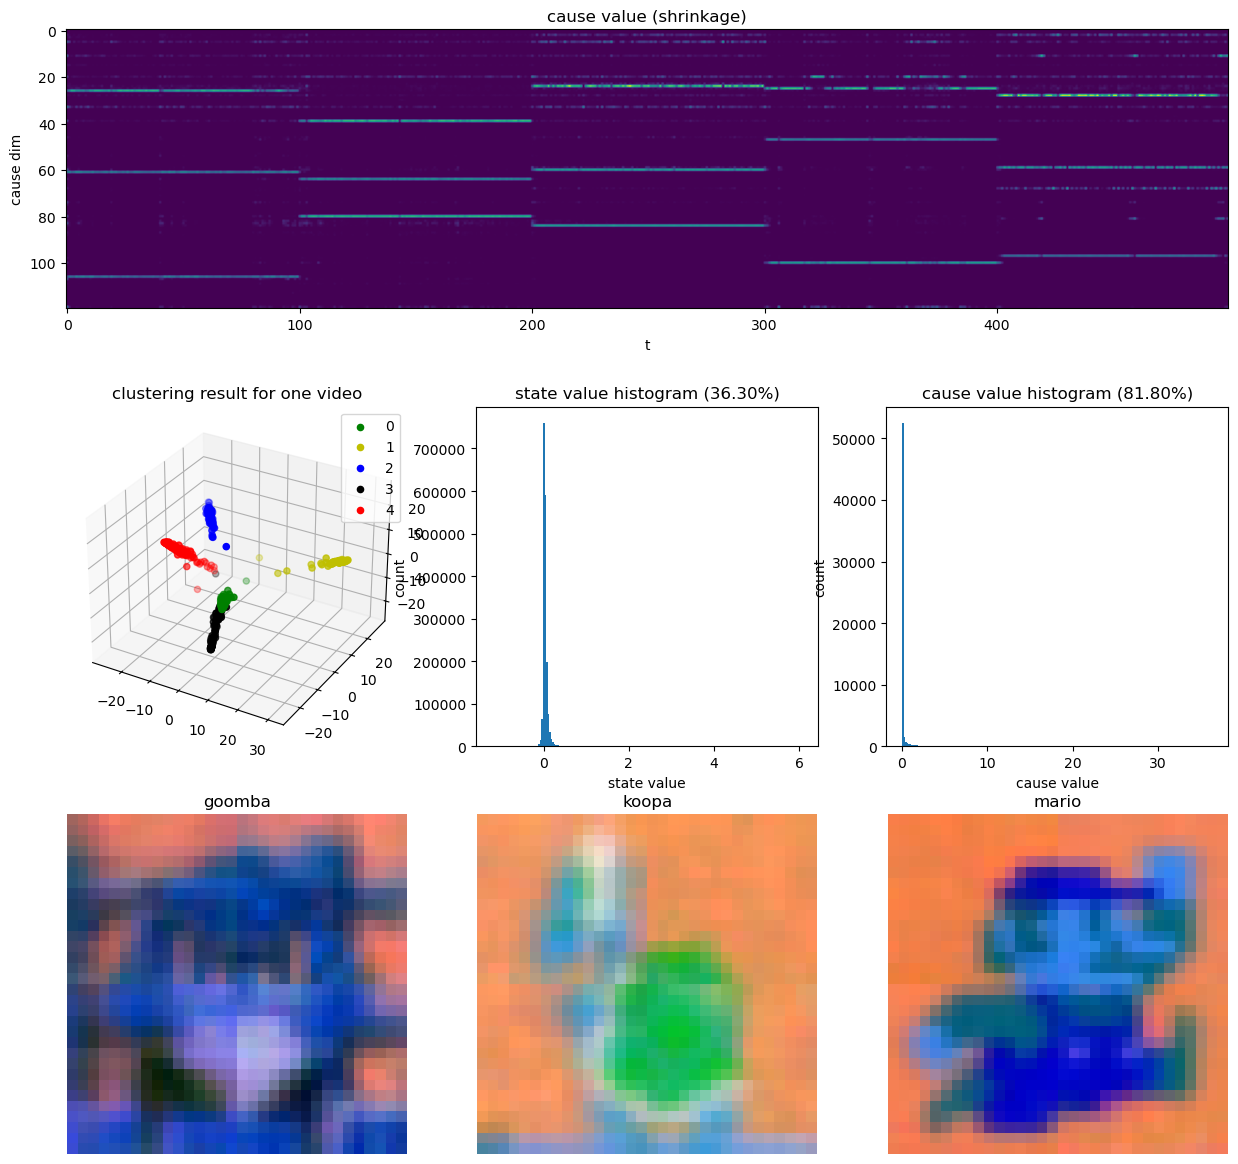

In [146]:
plot_result('shrinkage', 'mario')

In [327]:
from utils import Layer

loader = DataLoader(video_loader('Video_train.mat'), batch_size=5, shuffle=False, num_workers=1)

layer1 = Layer()
layer1 = layer1.to(device)

layer1.load_state_dict(torch.load("runs/working_layer1.pth.tar"))

X_list = []
U_list = []
with torch.no_grad():
    for _, data in enumerate(loader):
        data = data.to(device)
        X, U = layer1.inference(data)
        X_list.append(X.cpu().numpy())
        U_list.append(U.cpu().numpy())
        # print(X.shape, U.shape)

X = np.concatenate(X_list, axis=0)
U = np.concatenate(U_list, axis=0)

	 100 frame
	 200 frame
	 300 frame
	 100 frame
	 200 frame
	 300 frame
	 100 frame
	 200 frame
	 300 frame
	 100 frame
	 200 frame
	 300 frame
	 100 frame
	 200 frame
	 300 frame


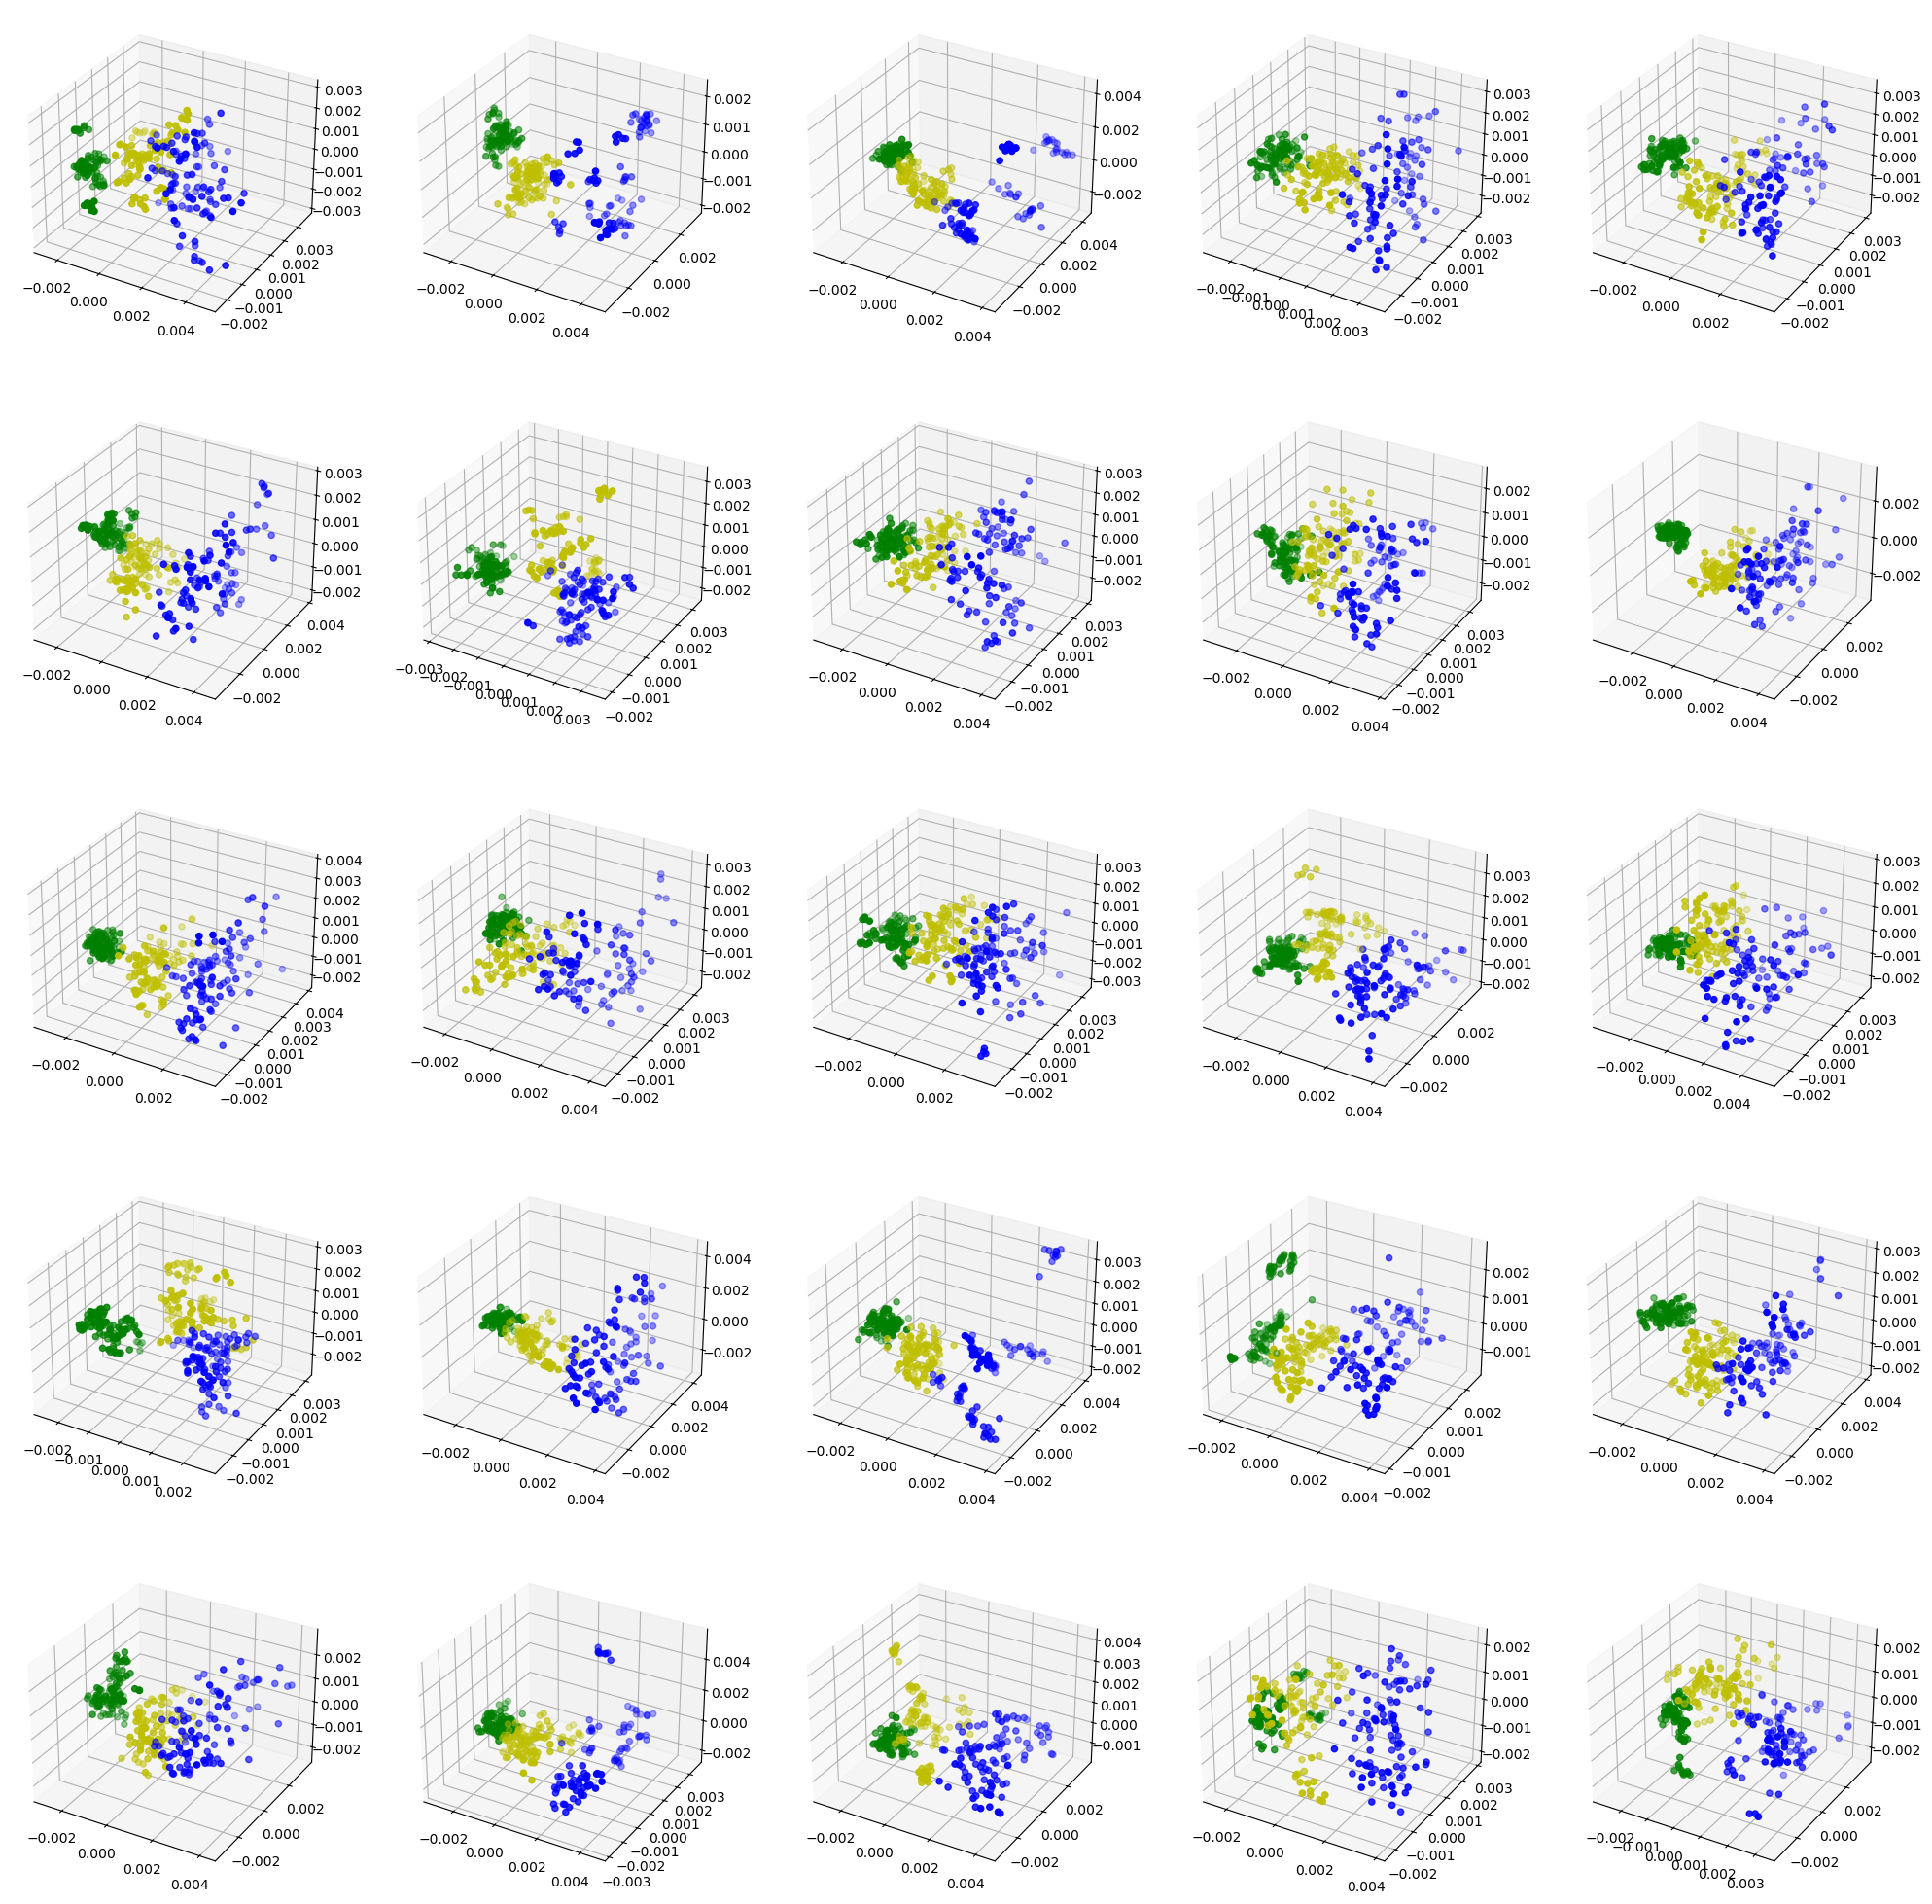

In [328]:
fig = plt.figure(figsize=(25,25))

ax_list = []
for idx in range(25):
    ax = fig.add_subplot(5, 5, idx+1, projection='3d')
    ax_list.append(ax)

for idx in range(25):
    # ax = fig.add_subplot(5, 5, idx+1, projection='3d')
    ax = ax_list[idx]
    test_U = U[idx].squeeze()
    #print(test_U.shape)
    
    U_1 = np.mean(np.abs(test_U), axis=0)
    new_U = np.zeros((U_1.shape[-1], U_1.shape[0]))
    
    for i in range(U_1.shape[-1]):
        sample = U_1[:,i].squeeze()
        new_U[i] = sample.flatten()
        #new_X[i] = X[:,:,:,i].flatten()
        
    #plt.imshow(new_U.T)
    #plt.show()
    
    pca = PCA(n_components=3)
    U_PCA = pca.fit_transform(new_U)
    #print(U_PCA.shape)
    #plt.scatter(U_PCA[:, 0], U_PCA[:, 1])
    
    i=0
    ax.scatter(U_PCA[i:100+i, 0], U_PCA[i:100+i, 1], U_PCA[i:100+i, 2], c='g', marker='o')
    ax.scatter(U_PCA[100+i:200+i, 0], U_PCA[100+i:200+i, 1], U_PCA[100+i:200+i, 2], c='y', marker='o')
    ax.scatter(U_PCA[200+i:300+i, 0], U_PCA[200+i:300+i, 1], U_PCA[200+i:300+i, 2], c='b', marker='o')
    #fig = plt.figure(figsize=(3,3))
    #ax = fig.add_subplot(projection='3d')
    #indx = [0,]
    #for idx in indx:
    #    ax.scatter(U_PCA[idx:100+idx, 0], U_PCA[idx:100+idx, 1], U_PCA[idx:100+idx, 2], c='g', marker='o')
    #    ax.scatter(U_PCA[100+idx:200+idx, 0], U_PCA[100+idx:200+idx, 1], U_PCA[100+idx:200+idx, 2], c='y', marker='o')
    #    ax.scatter(U_PCA[200+idx:300+idx, 0], U_PCA[200+idx:300+idx, 1], U_PCA[200+idx:300+idx, 2], c='b', marker='o')
        
    #plt.show()

sparsity of X 21.17 %
sparsity of U 7.45 %


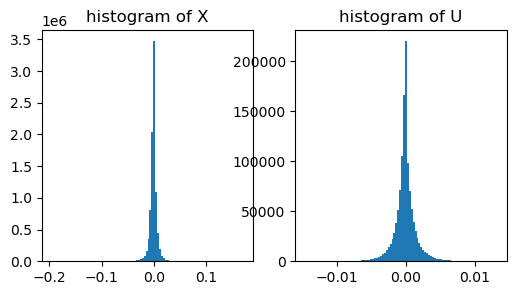

In [329]:
fig, ax = plt.subplots(1, 2, figsize=(6,3))
_ = ax[0].hist(X.flatten(), bins=100)
_ = ax[1].hist(U.flatten(), bins=100)

ax[0].set_title("histogram of X")
ax[1].set_title("histogram of U")

print("sparsity of X", "{:.2f}".format((X==0).sum() / X.size * 100), "%")
print("sparsity of U","{:.2f}".format((U==0).sum() / U.size * 100), "%")

In [310]:
layer1.A.shape
torch.norm(layer1.C, p=2, dim=2)

tensor([[[64.5067, 60.9160, 51.1313, 63.7538, 62.4056, 61.5515, 65.4973,
          60.2784, 60.0086, 53.9620, 39.2105, 59.2547, 57.9373, 60.1092,
          60.0216, 35.2266, 58.7276, 58.4344, 66.9540, 63.3022, 61.2039,
          56.6296, 58.6941, 45.1895, 52.1585, 63.0247, 57.1959, 54.2908,
          51.3172, 61.8913, 61.3659, 54.2240, 64.7380, 53.6119, 55.7155,
          55.9637, 52.0013, 53.6032, 55.5030, 66.4005, 52.8437, 62.1048,
          51.2754, 48.5015, 63.2188, 61.0319, 59.8820, 57.8154, 67.9566,
          42.4592, 60.1118, 65.0708, 36.4897, 72.5976, 56.7998, 66.0313,
          55.5618, 50.5921, 54.5917, 51.7161, 43.0720, 55.3750, 62.1097,
          58.2941, 56.0470, 41.6008, 64.8750, 68.7044, 48.9281, 57.1544,
          66.1195, 67.4374, 49.6255, 58.6757, 53.4445, 48.8347, 53.9286,
          57.5770, 63.3969, 56.7155, 58.3209, 57.9987, 63.6075, 59.5858,
          66.1886, 56.4437, 51.1709, 55.1390, 64.5630, 37.9290, 36.9367,
          52.0316, 56.0780, 57.6822, 72.3922, 47.61

# DPCN + Shrinkage
$$E_1(x_t,y_t,C,A) = \|y_t -Cx_t\|_2^2 + \lambda \|x_t-Ax_{t-1}\| + \| \gamma x_t\|_1$$
$$E_2(u_t,x_t,B) = \| \gamma x_t\|_1+\beta \| u_t\|_1$$ 
$$\gamma=\gamma_0\left[\frac{1+\exp(-Bu)}{2}\right]$$

(25, 4, 40, 1, 300)
(25, 4, 300, 1, 300)
(25, 600) (32, 32)


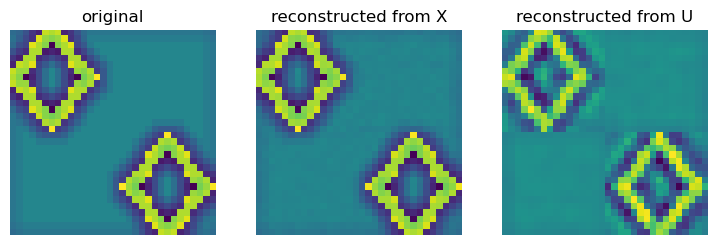

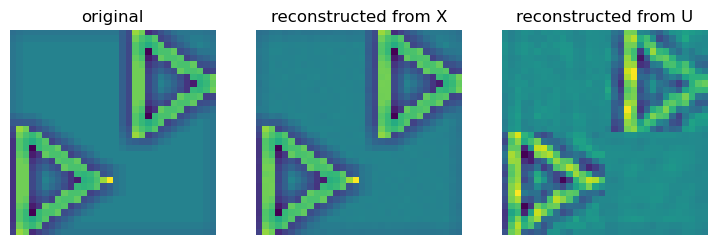

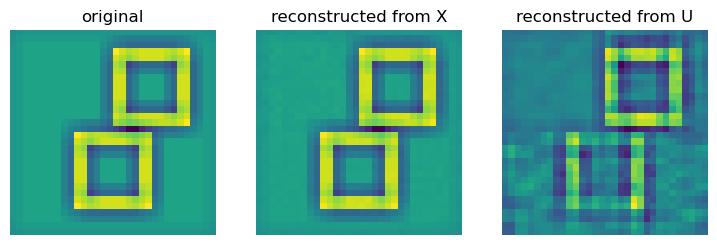

In [330]:
print(U.shape)
print(X.shape)
video = sio.loadmat('Video_train.mat')
print(video['M'].shape, video['M'][0][0].shape)
#layer1.B @ U
recon_img_X = np.zeros((32,32))
recon_img_U = np.zeros((32,32))
with torch.no_grad():
    for i in range(10,300,100):
        u = U[0,:,:,:,i]
        u = torch.FloatTensor(u).to(device)
        u = u.unsqueeze(0)
        x = X[0,:,:,:,i]
        x = torch.FloatTensor(x).to(device)
        x = x.unsqueeze(0)
        recon_u = layer1.C @ layer1.B @ u
        recon_x = layer1.C @ x
        # print(u.shape)
        # print(recon.shape)
        recon_x = recon_x.squeeze().cpu().numpy()
        recon_img_X[:16,:16] = recon_x[0,:].reshape(16,16)
        recon_img_X[:16,16:] = recon_x[1,:].reshape(16,16)
        recon_img_X[16:,:16] = recon_x[2,:].reshape(16,16)
        recon_img_X[16:,16:] = recon_x[3,:].reshape(16,16)
        
        recon_u = recon_u.squeeze().cpu().numpy()
        recon_img_U[:16,:16] = recon_u[0,:].reshape(16,16)
        recon_img_U[:16,16:] = recon_u[1,:].reshape(16,16)
        recon_img_U[16:,:16] = recon_u[2,:].reshape(16,16)
        recon_img_U[16:,16:] = recon_u[3,:].reshape(16,16)
        
        fig, ax = plt.subplots(1, 3, figsize=(9,3))
        ax[0].imshow(video['M'][0][i])
        ax[1].imshow(recon_img_X)
        ax[2].imshow(recon_img_U)
        ax[0].set_title("original")
        ax[1].set_title("reconstructed from X")
        ax[2].set_title("reconstructed from U")
        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        #plt.imshow(recon_img)
        #plt.show()
        #break

torch.Size([1, 4, 16, 16])


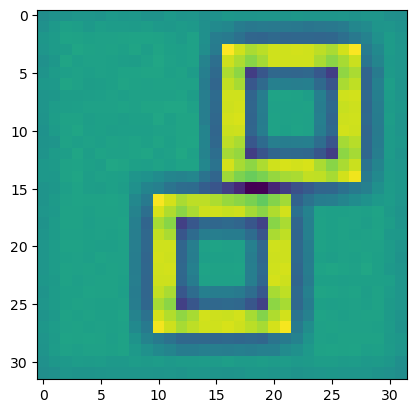

In [331]:
test = torch.FloatTensor(recon_x)
test = test.reshape(-1, 16, 16).unsqueeze(0)
print(test.shape)
# plt.imshow(test[3])
#torch.nn.Fold(1, (16,16), 1)(test).shape
test = test.view(1, 2, 2, 1, 16, 16)
test = test.permute(0, 3, 1, 4, 2, 5).contiguous()
test = test.view(1, 1, 32, 32)
plt.imshow(test.squeeze())

In [332]:
from utils import VIDLayer

layer2 = VIDLayer()
layer2 = layer2.to(device)
layer2.load_state_dict(torch.load("runs/layer1.pth.tar"))

with torch.no_grad():
    for _, data in enumerate(loader):
        data = data.to(device)
        X, U = layer2.inference(data)
        x_t_minus_1 = torch.randn_like(X[:, :, :, :, 0])
        video_recon, _, _ = layer2(X,U, x_t_minus_1)
        break
    
video_recon = video_recon.squeeze().cpu().numpy()
print(video_recon.shape)

	 100 frame
	 200 frame
	 300 frame
(5, 32, 32, 300)


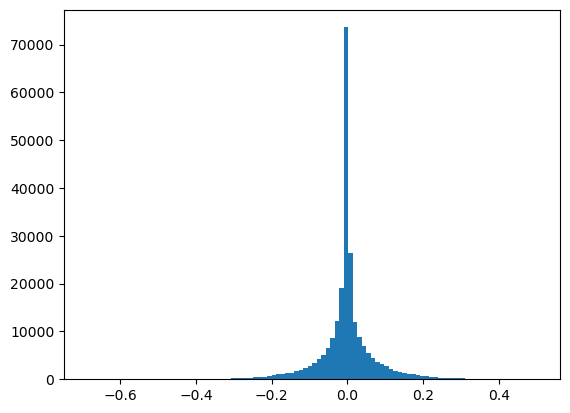

In [108]:
_ = plt.hist(U.cpu().numpy().flatten(), bins=100)

(10, 8, 8, 300)


Text(0.5, 1.0, 'FISTA Cuase Histogram')

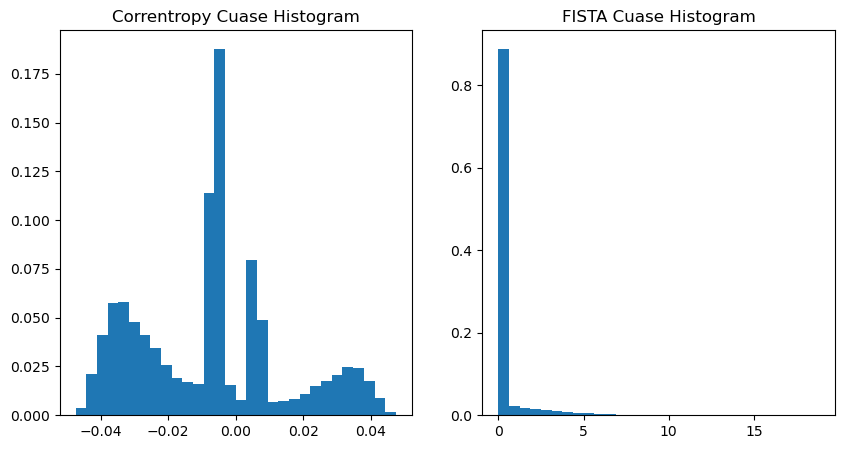

In [21]:
U_FISTA = sio.loadmat("U_FISTA.mat")['U_FISTA']
print(U.shape)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(U.flatten(), bins=30, weights=np.ones(U.flatten().shape) / U.flatten().shape, label='CRR')
ax[1].hist(U_FISTA.flatten(), bins=30, weights=np.ones(U_FISTA.flatten().shape) / U_FISTA.flatten().shape, label='FISTA')
ax[0].set_title('Correntropy Cuase Histogram')
ax[1].set_title('FISTA Cuase Histogram')

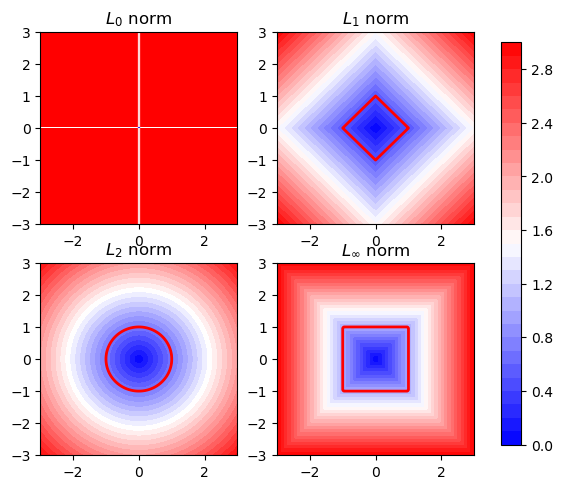

In [47]:
p_values = [0., 1, 2, np.inf]
xx, yy = np.meshgrid(np.linspace(-3, 3, num=101), np.linspace(-3, 3, num=201))
fig, axes = plt.subplots(ncols=(len(p_values) + 1)// 2,
                     nrows=2, figsize=(7, 5.5))
for p, ax in zip(p_values, axes.flat):
    if p == 0:
        zz = (xx != 0).astype(int) + (yy != 0).astype(int)
        ax.imshow(zz, cmap='bwr', extent=(xx.min(),xx.max(),yy.min(),yy.max()), aspect="auto")
    else:
        if np.isinf(p):
            zz = np.maximum(np.abs(xx),np.abs(yy))
        else:
            zz = ((np.abs((xx))**p) + (np.abs((yy))**p))**(1./p)
        ax.contourf(xx, yy, zz, 30, cmap='bwr')
        ax.contour(xx,yy,zz, [1], colors='red', linewidths = 2) 
    if p < float('inf'):
        p = int(p)
        ax.set_title(f'$L_{p}$ norm')
    else:
        ax.set_title(f'$L_\infty$ norm')

cbar = fig.colorbar(ax.collections[0], ax=axes.ravel().tolist(), shrink=0.95, aspect=20)
plt.show()